In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import io
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [13]:
# Import Data
print("\n---- Dataset Info ----")
gesture_data = pd.read_csv("imu_data.csv")

# Separate inputs and outputs
x = gesture_data.iloc[:, :-1].values  # Input (first 300 columns)
y = gesture_data.iloc[:, -1].values   # Output (column 301)

# Convert string labels to numeric (0-3)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# Save the encoder for future use (important for inference)
joblib.dump(label_encoder, "label_encoder.pkl")

# Print dataset info
print(f"gesture_data.shape = {gesture_data.shape}")
print(f"features.shape = {x.shape}")
print(f"labels.shape = {y.shape}")
print("Label Mapping:", label_mapping)
print("\n")


---- Dataset Info ----
gesture_data.shape = (125, 301)
features.shape = (125, 300)
labels.shape = (125,)
Label Mapping: {'bathroom': 0, 'food': 1, 'hello': 2, 'please': 3, 'yes': 4}




In [14]:
# Settings
inputShape = (300,) # Change this to match the size of input
nsamples = 125      # Number of samples to use as a dataset
val_ratio = 0.1     # % of samples that should be held for validation set
test_ratio = 0.1    # % of samples that should be held for test set
tflite_model_name = 'SIGNSPEAK_MLP_full_model'    # Will be given .tflite suffix
c_model_name = 'SIGNSPEAK_MLP_full_model'         # Will be given .h suffix

Training: (100, 300), Validation: (12, 300), Testing: (13, 300)


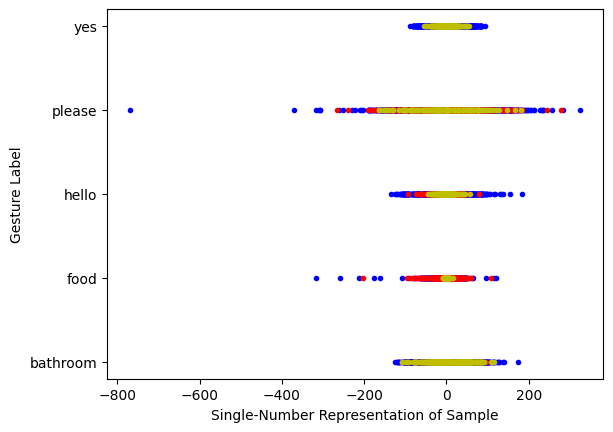

In [15]:
# Split the dataset into training, validation, and test sets (80% train, 10% validation, 10% test)
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training: {x_train.shape}, Validation: {x_val.shape}, Testing: {x_test.shape}")

# Check that our splits add up to nsamples
assert(x_train.shape[0] + x_val.shape[0] + x_test.shape[0]) == nsamples

# Get unique numerical labels and corresponding string labels
unique_labels = np.unique(y)
string_labels = label_encoder.inverse_transform(unique_labels)

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_val, y_val, 'y.', label="Validate")


plt.yticks(unique_labels, string_labels) # Set y-axis ticks and labels

plt.xlabel("Single-Number Representation of Sample") #
plt.ylabel("Gesture Label")
plt.show()

In [16]:
# Create a model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(300,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(5, activation='softmax')  # Ensure 5 gesture classes
])

model.summary() # Print model summary

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,509 (84.02 KB)

 Trainable params: 21,509 (84.02 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Add optimizer, loss function, and metrics to model and compile it
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# Train model
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=16,  # Small batch size for generalization
                    validation_data=(x_val, y_val))


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1790 - loss: 19.3575 - val_accuracy: 0.3333 - val_loss: 9.8730
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4768 - loss: 4.8926 - val_accuracy: 0.6667 - val_loss: 3.5370
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7836 - loss: 1.2214 - val_accuracy: 0.7500 - val_loss: 1.7292
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9403 - loss: 0.3285 - val_accuracy: 0.8333 - val_loss: 1.0690
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9290 - loss: 0.2117 - val_accuracy: 0.8333 - val_loss: 0.9283
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9702 - loss: 0.1060 - val_accuracy: 0.8333 - val_loss: 0.7718
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9611 - loss: 0.1056 - val_accuracy: 0.8333 - val_loss: 0.5523
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9751 - loss: 0.0578 - val_accuracy: 0.8333 - val_loss: 0.4459
Epoch 9

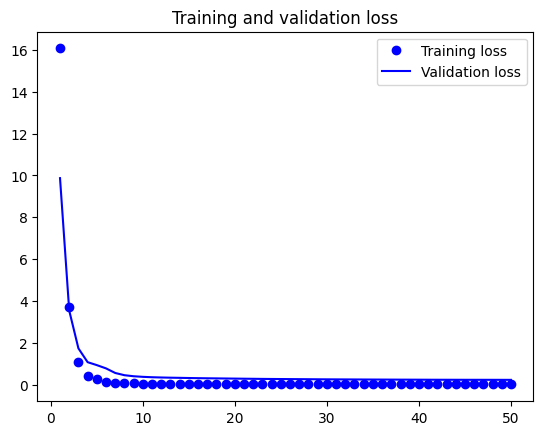

In [19]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


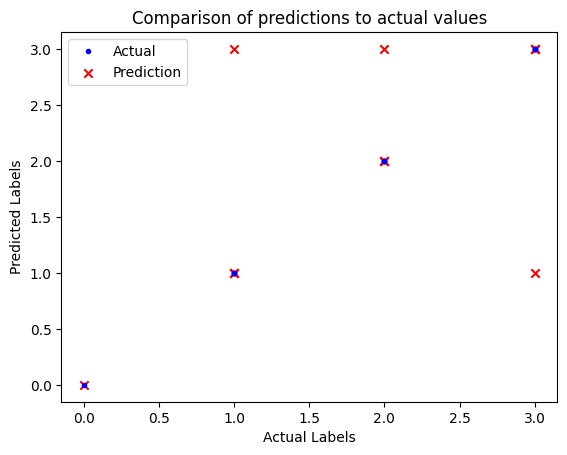

In [20]:
# Plot predictions against actual values
predictions = model.predict(x_test)
predicted_labels = np.argmax(predictions, axis=1)  # Get predicted class labels

plt.clf()
plt.title("Comparison of predictions to actual values")
plt.plot(y_test, y_test, 'b.', label='Actual') # Plot actual vs actual for diagonal line
plt.scatter(y_test, predicted_labels, c='r', marker='x', label='Prediction') # Scatter predicted vs actual
plt.xlabel("Actual Labels")
plt.ylabel("Predicted Labels")
plt.legend()
plt.show()

In [21]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7692 - loss: 2.9385
Test Accuracy: 0.7692


In [22]:
saved_model_dir = "./saved_model"
model.export(saved_model_dir)

# Convert to TensorFlow Lite with backward compatibility
converter = tf.lite.TFLiteConverter.from_saved_model("./saved_model")

# Optimize for compatibility with older TFLite runtimes
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter._experimental_lower_tensor_list_ops = False

tflite_model = converter.convert()

# Save the TFLite model
with open("SIGNSPEAK_MLP_compatible.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved: SIGNSPEAK_MLP_compatible.tflite")

INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


Saved artifact at './saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  12935775824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12921731600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12921726992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12921731408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12921732752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  12921731024: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved: SIGNSPEAK_MLP_compatible.tflite


W0000 00:00:1741483479.146774  485652 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1741483479.146968  485652 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
2025-03-08 20:24:39.147822: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ./saved_model
2025-03-08 20:24:39.148061: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-08 20:24:39.148065: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: ./saved_model
2025-03-08 20:24:39.149936: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-03-08 20:24:39.150237: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-08 20:24:39.164531: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: ./saved_model
2025-03-08 20:24:39.168008: I tensorflow/cc/saved_model/loader.cc:462] Sav

In [23]:
def hex_to_c_array(hex_data, var_name):

    c_str = ''

    # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

    # Add array length at top of file
    c_str += 'unsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

    # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data):

        # Construct string from hex
        hex_str = format(val, '#04x')

        # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

    # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

    # Close out header guard
    c_str += '#endif // ' + var_name.upper() + '_H'

    return c_str

In [24]:
# Write TFLite model to a C source (or header) file
with open(c_model_name + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, c_model_name))

In [25]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="SIGNSPEAK_MLP_full_model.tflite")
interpreter.allocate_tensors() # allocate memory for tensors

# Get input and output tensors (to know which format the input, output needs to be in)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
# print(input_details,output_details)

# Set up the input
# Change x[0] to a different number to check another sample uptil x[124]
x0 = x[0].astype(np.float32) # Need to convert it to float32 since 'dtype': <class 'numpy.float32'>
x0 = np.array(x0).reshape(1, 300)  # Need to send a 2D input (so reshape it to 1,300)

# Run inference
interpreter.set_tensor(input_details[0]['index'], x0) # Load the input
interpreter.invoke() # Run
predictions = interpreter.get_tensor(output_details[0]['index']) # Get the results

# Decode class
predicted_class = np.argmax(predictions) # Get the index of the majority class (highest confidence)
label_encoder = joblib.load("label_encoder.pkl") # Load the encoder
predicted_label = label_encoder.inverse_transform([predicted_class]) # Convert the number back to the gesture

# Output
print("Predicted Gesture:", predicted_label[0])

Predicted Gesture: hello


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
